
# Fire Kite Analysis in Gaza strip area

### Use of data mining methods for explore the phenomenon of Fire-Kites launched from Gaza



created by [**Etzion Harari**](https://github.com/EtzionData) and [**Asher Chazan**](https://github.com/ashercha)

![img](https://doc-14-a8-mymaps.googleusercontent.com/untrusted/hostedimage/ipoo8mp319b8e6mg6ncdrjunqg/s8vfnugmcub72seqcntcacs0cc/1603390863750/Df5aJXzzJ_VZsWx8RPJQ9JMPHivr6YGw/13576183864254850826/5AF2TALovrR4feukkEEa1Ltxo7KyCI3QrgigN7l771FkXDHBwBe3uahV_gX3fQFMHHuw7jvQVgKHypf9u6go7vEpEJ2s3gVyb_2xUwBVt4j38j_kunYxJVH82hsW9agPeYjXeFLZZvw1-Ihtc1kjYcHNQwDdcOGFM1sVz2r3wEBcthvQ-jlkzqrm25l-MkaF-QFypDEEfzJQ7E1UPe5LSdhFp8X-_9123xYbpqTJhlvy360bZ86W8KMPN6RUQLHghwonVK3uJNprkM_n1f8C-JQOHs5JIt9Aj_Q?session=0&fife=s16383)

## Introduction
As of 2018, balloons and incendiary kites have been launched from the Gaza Strip towards Israeli territory. These measures have led to **hundreds of fires** in the Gaza surrounding areas. Since launching incendiary means towards Israel is a **large-scale effort** (Almost 2,000 documented events), we believe that the **weather** is a significant consideration in launching the means. This hypothesis is based on the fact that parameters such as wind direction and speed affect the trajectory of the balloons.

Therefore, we chose to use meteorological data on the **wind direction** documented in the Gaza Strip each day. With this data, we will try to pinpoint the source of the balloon launches from the Gaza Strip itself. In addition, we will also use additional data mining tools as well as additional Python packages that we have developed [(**see here**)](https://github.com/EtzionData?tab=repositories) before, for the research.

## Data
Landing points of fire kites in Israeli territory. Data includes coordinates in wgs84 geo dd, date and nickname for each landing location.

source: [landing points](https://www.google.com/maps/d/u/0/viewer?mid=1U3A57H6TCphdux7Sf7dl4z2-1F3vmecJ)

Meteorological records in the required date range, from the **Israel Meteorological Service** (IMS).

source : [IMS](https://ims.data.gov.il/ims/7)



## Analysis:

### Import libraries & data
First, we will import the relevant libraries for the project.

Second, load the data files:
- "**kite.csv**": kites fall points
- "**weather.csv**": weather records

We will also upload the following files:
- "**cities**": Gaza cities locations
- "**gaza_geo**": coordinates of Gaza boundary (wgs84 geo) 
- "**gaza_utm**": coordinates of Gaza boundary (wgs84 utm)


In [3]:
# import
# pandas & numpy
import numpy as np
import pandas as pd

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patheffects as PathEffects
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap as colormap

# calculation & geo-tools
from simplekml import Kml
from random import randint
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon as Poly
from utm import from_latlon as to_utm, to_latlon as to_geo

# load files
kite = pd.read_csv(r'data\kites.csv')           # kites fall points
weth = pd.read_csv(r'data\weather.csv')         # weather records from Gata Strip area
city = np.load(r'data\cities.npy')              # load Gaza cities loacations
gaza = {'geo' : np.load(r'data\gaza_geo.npy'),  # coordinates of Gaza boundary (GEO)
        'utm' : np.load(r'data\gaza_utm.npy')}  # coordinates of Gaza boundary (UTM)

### fix, convert & merge data
Now, we will do some processing of the data,
so that we can make simple use of them in the further stages of the research.

In [4]:
# convert wgs84 geo dd coordinates to wgs84 utm 36 north coordinates:
kite['xy_utm']= kite.apply(lambda r: to_utm(r['y'],r['x'] , 36, 'U')[:2],axis=1)
kite['x_utm'] = kite['xy_utm'].apply(lambda r: r[0])
kite['y_utm'] = kite['xy_utm'].apply(lambda r: r[1])

# fix hebrew text
kite['name'] = kite['name'].apply(lambda w: w.replace('\u200e','').replace('\xa0',''))

# fix date format 
def fix_date(date):
    d, m, y = date.split('/')
    return str(int(d))+'/'+str(int(m))+'/'+str(int(y))

kite['date_field'] = kite['date_field'].apply(fix_date)
weth['date'] = weth['date'].apply(fix_date)

# merge dataframes
data = pd.merge(kite, weth, how='inner', left_on=['date_field'], right_on=['date'])

### Initial plots:

#### Wind angle standard deviation:
1) plot the **standard deviation** (sd) of the wind direction (from the merged dataframe):

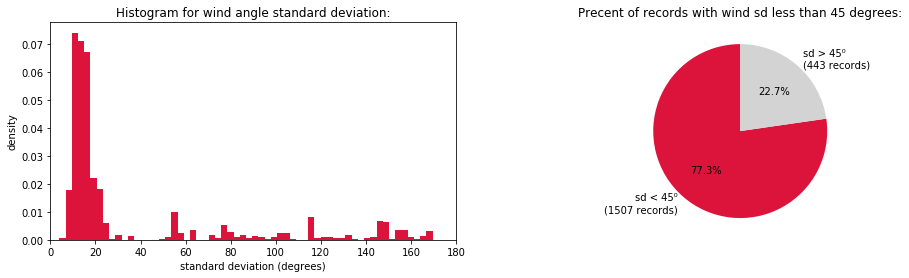

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.hist(data['angle_std'],bins = 60, density=True, color='crimson')
ax1.set_title('Histogram for wind angle standard deviation:')
ax1.set_xlabel('standard deviation (degrees)')
ax1.set_ylabel('density')
ax1.set_xlim(0,180)

degree = 45
n = data.shape[0]
sizes = [len(data['angle_std'][data['angle_std']< degree])/n,
         len(data['angle_std'][data['angle_std']>=degree])/n]
label = [f'sd < {degree}⁰\n({int(sizes[0]*n)} records)', 
         f'sd > {degree}⁰\n({int(sizes[1]*n)} records)']
ax2.pie(sizes, colors=['crimson','lightgrey'],startangle=90, labels=label, autopct='%1.1f%%')
ax2.set_title(f'Precent of records with wind sd less than {degree} degrees:')

plt.show()
        

It can be seen that most of the records have a standard deviation of less than 45 degrees.




#### Kites fall points:
2) plot the kites fall points:

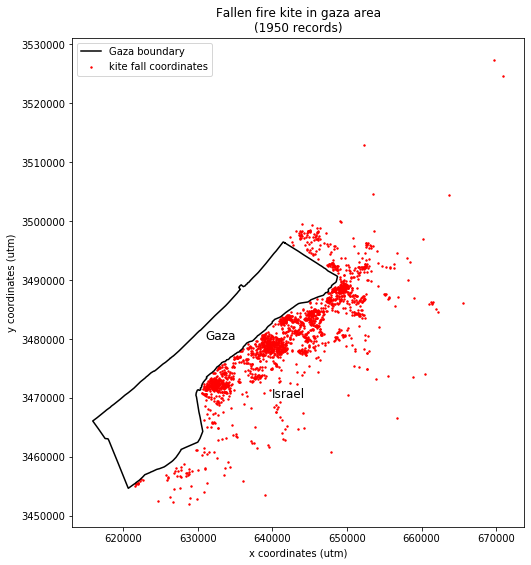

In [6]:
plt.figure(figsize=(8.1,9))
plt.plot(gaza['utm'][:,0],gaza['utm'][:,1], c='black', label = 'Gaza boundary')
plt.scatter(kite['x_utm'],kite['y_utm'], c='red',s =2, label = 'kite fall coordinates')
plt.title(f'Fallen fire kite in gaza area\n({kite.shape[0]} records)')
plt.xlabel('x coordinates (utm)')
plt.ylabel('y coordinates (utm)')
plt.text(640000, 3470000,'Israel',fontsize = 12)
plt.text(631000, 3480000, 'Gaza', fontsize = 12)
plt.legend(loc='upper left')
plt.savefig('fallen_points')
plt.show()

### Create kite fall points heatmap

From looking at the plot, we can see areas with higher density of kite fall points. We would like create a heatmap to examine in which areas there are more kite falls.

For the heatmap calculation we will use our **cumulative-heatmap** code. This code was developed to allow a quick calculation of a heatmap even based on a large amount of records. You can see full documentation of this code here: **https://github.com/EtzionR/cumulative-heatmap-calculation**.

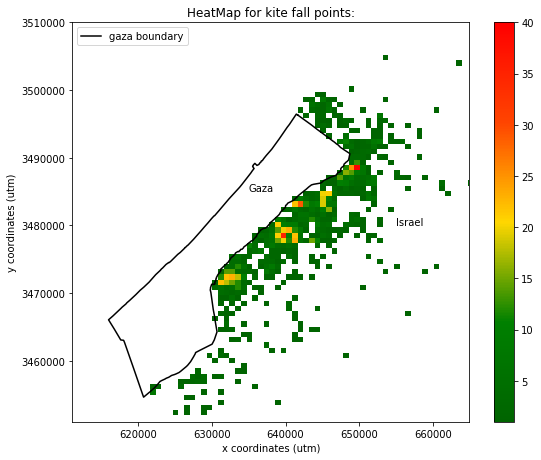

In [7]:
# calculate heatmap
from cumulative_heatmap import HeatMap
heatmap = HeatMap(data['xy_utm'], 64).get_map()

# plot results
MAP = colormap.from_list('',['darkgreen','green','gold','orangered','red'])
fig, ax = plt.subplots(1, 1, figsize=(8.1, 6.5))
ax.set_title(f'HeatMap for kite fall points:')
ax.plot(gaza['utm'][:,0],gaza['utm'][:,1],c='black',label='gaza boundary')
p = PatchCollection([Polygon(square['xy'], True) for square in heatmap], cmap=MAP)
p.set_array(np.array([square['count'] for square in heatmap]))
ax.add_collection(p)
ax.set_xlim(611000, 665000)
ax.set_ylim(3451000,3510000)
ax.text(635000, 3485000, 'Gaza')
ax.text(655000, 3480000, 'Israel')
ax.set_xlabel('x coordinates (utm)')
ax.set_ylabel('y coordinates (utm)')
ax.legend(loc='upper left')
fig.colorbar(p, ax=ax)
plt.tight_layout()
plt.savefig('kite_heatmap')
plt.show()

Now, it is certainly possible to identify areas with a large amount of balloons and kites that have crashed. At the same time, it is still difficult to precisely delineate these areas and separate them from each other. In order to improve the results, we will use clustering.

### Clustering fall points:
For the clustering we must choose a suitable algorithm for grouping the records as well as the appropriate parameter. In order to efficiently and quickly identify the main kites destinations, we will use the **HDBSCAN algorithm**. An advantage of this algorithm (in addition to its output quality), is that it classifies some of the records as **not associated** with any cluster (label = -1).

Now, to select the appropiate parameter that will get the optimal result, we will use our code **Clustering-by-Silhouette**. This code compare the clustering results over a wide range of their parameter values (in the case of HDBSCAN, the minimum number of records to define cluster). The comparison is made by the **silhouette score** and at the end the output that leads to the highest silhouette score is chosen. Examples and full documentation of the code here: **https://github.com/EtzionR/Clustering-by-Silhouette**

In [8]:
# optimal clustering
from clustering_by_silhouette import silhouette_clustering
data['cls'] = silhouette_clustering(data[['x_utm','y_utm']], typ='hdbscan', org=10, lim=20) # this is the range we want to check

# find each cluster name
def find_name(names):
    count = {}
    for name in names:
        if name in count:
            count[name]+=1
        else:
            count[name] =1
    return max(count, key=lambda k: count[k])

names ={-1: 'undefined'}
cls = np.unique(data['cls'])
for c in cls[cls>-1]:
    sub = data[data['cls']==c]
    names[c] = find_name(sub['name'])

# append cluster names to "data"
data['cls_name'] = data['cls'].apply(lambda label: names[label])


cluster kind: hdbscan,   input value = 10,   silhouette = 35.7%
cluster kind: hdbscan,   input value = 11,   silhouette = 36.9%
cluster kind: hdbscan,   input value = 12,   silhouette = 41.1%
cluster kind: hdbscan,   input value = 13,   silhouette = 36.7%
cluster kind: hdbscan,   input value = 14,   silhouette = 40.9%
cluster kind: hdbscan,   input value = 15,   silhouette = 37.1%
cluster kind: hdbscan,   input value = 16,   silhouette = 40.0%
cluster kind: hdbscan,   input value = 17,   silhouette = 41.0%
cluster kind: hdbscan,   input value = 18,   silhouette = 41.1%
cluster kind: hdbscan,   input value = 19,   silhouette = 41.1%
cluster kind: hdbscan,   input value = 20,   silhouette = 41.5%


#### Plot clustering  results
Now, we will plot the results of the clustering process so we can see how many records are associated with each cluster. Each such cluster is given a **cluster name** based on the most dominant name between the records that composed it.

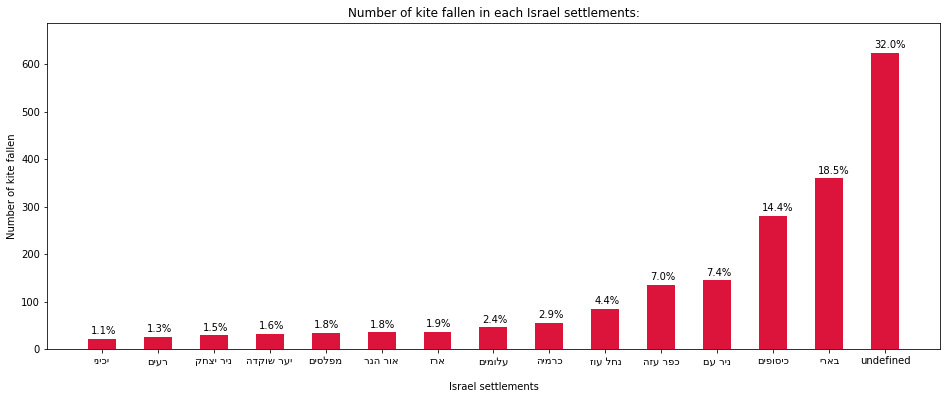

In [9]:
# plot results
cls_count= data['cls_name'].value_counts(ascending=True).to_dict()
cls_name = [txt if txt=='undefined' else txt[::-1] for txt in cls_count.keys()]
cls_value= list(cls_count.values())

plt.figure(figsize=(16, 6))
plt.bar(cls_name, cls_value, width = 0.5, color='crimson')
for i in range(len(cls_value)): plt.text(i-0.2,cls_value[i]+10, str(round(cls_value[i]/n*100,1))+"%")
plt.xlabel('\nIsrael settlements')
plt.ylabel('Number of kite fallen')
plt.ylim(0,max(cls_value)+(max(cls_value)/10))
plt.title('Number of kite fallen in each Israel settlements:')
plt.savefig('kite_to_set.png')
plt.show()

It can be seen that many of the kites are not associated with any of the clusters. We also can seen a number of **key destinations** that a significant percentage of kites are aimed at. Such destinations are:
- בארי
- כיסופים
- ניר עם

Now we will want to show the boundaries of each cluster on the map.

#### Create Convex-Hull boundary for each cluster:
We will calculate for each cluster its **Convex-Hull** boundaries, and use their coordinates to display them on the map:

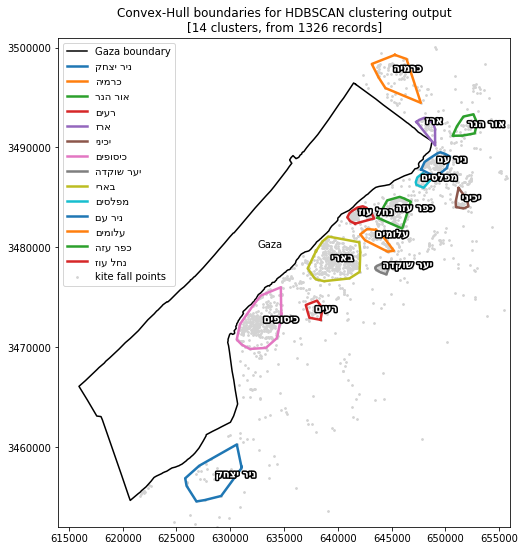

In [10]:
def convex_hull(df):
    rows = [df.iloc[i] for i in range(df.shape[0])]
    points = np.array([[r['x_utm'], r['y_utm']] for r in rows])
    hull = ConvexHull(points).vertices
    bound = [(x, y) for x, y in points[hull, :]]
    return bound+[bound[0]]

convex = []
for c in cls[cls>-1]:
    sub = data[data['cls_name']==names[c]]
    convex.append({'name':names[c], 'xy':convex_hull(sub), 'count':sub.shape[0]})

plt.figure(figsize=(8.1,9))
plt.plot(gaza['utm'][:,0],gaza['utm'][:,1], c='black', label = 'Gaza boundary')
plt.scatter(data['x_utm'], data['y_utm'], s=3, c='lightgrey', label='kite fall points')
for c in convex:
    x = [x for x,y in c['xy']]
    y = [y for x,y in c['xy']]
    plt.plot(x,y, label = c['name'][::-1],linewidth=2.5)
    t = plt.text(sum(x)/len(x), sum(y)/len(y), c['name'][::-1],weight='bold',color='white',)
    t.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='k')])
plt.title(f'Convex-Hull boundaries for HDBSCAN clustering output\n[{len(convex)} clusters, from {n-cls_value[-1]} records]')
plt.text(632500,3480000,'Gaza')
plt.xlim(614000, 656000)
plt.ylim(3452000,3501000)
plt.legend(loc='upper left')
plt.show()


It can now be seen how the Convex-Hull outputs allows us to fins the clusters to boundaries. Looking at the plot, it appears that most of the kite launch-targets are located in the **northern** part of the Gaza area.

### Calculate launch zone for each kite record
Now, we want to investigate where the fire kites came from in the Gaza Strip. To do this, we will use the wind angle of each balloon and the standard deviation of wind angle. We use this data to create the **sector shape**. Each sector represent estimation for the area from which the kite was launched. The calculation of the sector will be performed using our **create-sector-shape** code. Documentation and examples of the code are available here: [**https://github.com/EtzionR/create-sector-shape-KML-file**](https://github.com/EtzionR/create-sector-shape-KML-file)

Note: The sector is calculated according to the following figure. The **distance** parameter entered for the project needs is 10 KM:
![sectors](https://github.com/EtzionR/create-sector-shape-KML-file/raw/master/Pictures/sector_figure.png)

In [11]:
# calculate sector area
from sector_creator import create_sector_kml

data['distance'] = 10000
create_sector_kml(data,'x','y','angle','distance','angle_std')     # 'POLYGON' field created
data['POLYGON_utm'] = [[to_utm(y, x , 36, 'U')[:2] for x,y in xy] for xy in data['POLYGON']]

#### Plot example of the sectors which calculated
now, we plot some of the sectors we calculated

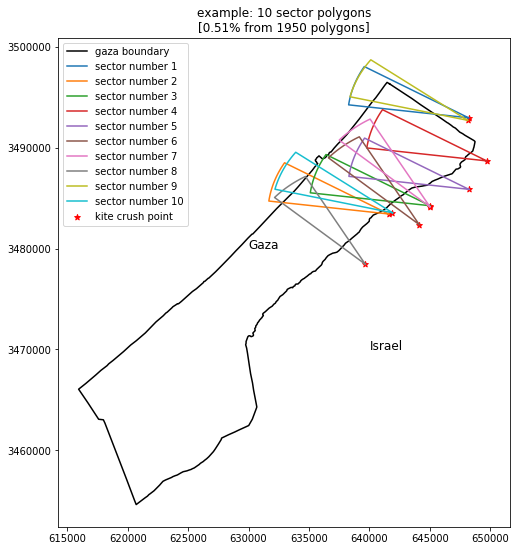

In [12]:
# plot sectors examples 
sector_num =10
plt.figure(figsize=(8.1, 9))
example = data['POLYGON_utm'][:sector_num]
plt.plot(gaza['utm'][:,0],gaza['utm'][:,1],c='black',label='gaza boundary')
for i in range(len(example)):
    x = [x for x,y in example[i]]
    y = [y for x,y in example[i]]
    plt.plot(x,y, label=f'sector number {i+1}')
plt.title(f'example: {len(example)} sector polygons\n'
          f'[{round(len(example)/n*100,2)}% from {n} polygons]')
kite_x = [exm[0][0] for exm in example]
kite_y = [exm[0][1] for exm in example]
plt.scatter(kite_x,kite_y, c='red', marker='*',label='kite crush point')
plt.text(640000, 3470000,'Israel',fontsize = 12)
plt.text(630000, 3480000, 'Gaza', fontsize = 12)
plt.legend(loc='upper left',fontsize=10)
plt.show()

#### Calculate sectors heatmap (create initial squares)
Now that we have calculated the sectors, we would like to check in which areas they intersect. This way we can find areas from which a fire kite is **more likely** to be launched.
In the first step, we want to calculate a **square map** of the entire area of Gaza strip, so that we can use them to calculate for each area in the strip how many sectors intersect with it.

We also plot the initial squares which calculated

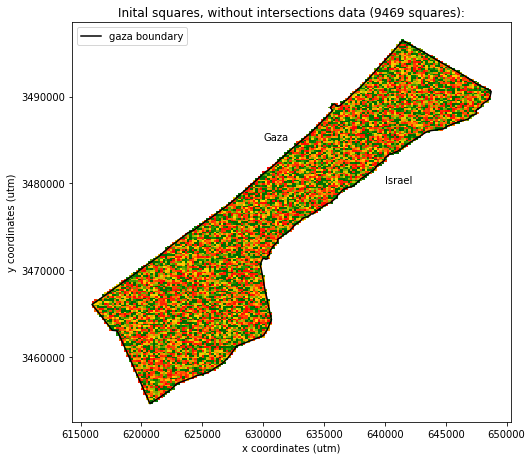

In [13]:
# calculate initial squares
square = lambda x,y,s: [(x,y), (x+s,y), (x+s,y+s), (x,y+s), (x,y)] 
geometry = lambda poly: poly.__geo_interface__['coordinates'][0]
gaza['poly'] = Poly(gaza['utm'])

min_x, min_y, side = min(gaza['utm'][:,0]), min(gaza['utm'][:,1]), 200
max_x, max_y = max(gaza['utm'][:,0]), max(gaza['utm'][:,1])

x_len = int(((max_x - min_x)//side)+1)
y_len = int(((max_y - min_y)//side)+1)


# create heatmap squares
squares = [square(min_x+(i*side), min_y+(j*side),side) for j in range(y_len)  # create initial square
                                                       for i in range(x_len)]
squares = [{'geometry':Poly(wkt), 'count':0} for wkt in squares]             # define coordinates as shapely.Polygons
squares = [p for p in squares if p['geometry'].intersects(gaza['poly'])]     # filter square outside Gaza boundaries

# plot initial squares
fig, ax = plt.subplots(1, 1, figsize=(7.5, 6.5))
ax.set_title(f'Inital squares, without intersections data ({len(squares)} squares):')
ax.plot(gaza['utm'][:,0],gaza['utm'][:,1],c='black',label='gaza boundary')
p = PatchCollection([Polygon(geometry(p['geometry']), True) for p in squares], cmap=MAP)
p.set_array(np.array([randint(0,100) for i in range(len(squares))])) # just for visualization
ax.add_collection(p)
ax.text(630000, 3485000, 'Gaza')
ax.text(640000, 3480000, 'Israel')
ax.set_xlabel('x coordinates (utm)')
ax.set_ylabel('y coordinates (utm)')
ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig('initial_squares')
plt.show()

#### Calculate sectors heatmap (calculate intersections)
Now, we calculate for each of the squares with how much of the sectors it intersects. We will only save the squares with which intersect with least one sector, so we can calculate a heat map of the launch sectors.

In [14]:
# calculate intersections
sectors = [Poly(xy) for xy in data['POLYGON_utm']]
for s in range(len(squares)):
    square = squares[s]
    for sector in sectors:
        if square['geometry'].intersects(sector):
            square['count'] +=1
    if s%1000==0: print(f'square number {s+1} calculated!')

squares = [square for square in squares if square['count']>0]

square number 1 calculated!
square number 1001 calculated!
square number 2001 calculated!
square number 3001 calculated!
square number 4001 calculated!
square number 5001 calculated!
square number 6001 calculated!
square number 7001 calculated!
square number 8001 calculated!
square number 9001 calculated!


#### Calculate sectors heatmap (plot results)
now, we just plot the output of the heatmap calculation

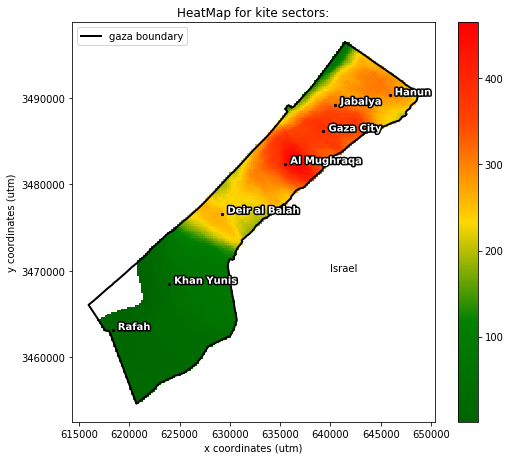

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 6.5))
ax.set_title(f'HeatMap for kite sectors:')
ax.plot(gaza['utm'][:,0],gaza['utm'][:,1],c='black',label='gaza boundary',linewidth=2)
p = PatchCollection([Polygon(geometry(s['geometry']), True) for s in squares], cmap=MAP)
p.set_array(np.array([s['count'] for s in squares]))
ax.add_collection(p)
for i in range(len(city)):
    txt = ax.text(int(city[i,1])+500,int(city[i,2]),city[i,0], color='white', weight='bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='k')])
ax.scatter([int(j) for j in city[:,1]],[int(j) for j in city[:,2]],s=5,color='k')
ax.text(640000, 3470000, 'Israel')
ax.set_xlabel('x coordinates (utm)')
ax.set_ylabel('y coordinates (utm)')
ax.legend(loc='upper left')
fig.colorbar(p, ax=ax)
plt.tight_layout()
plt.savefig('sectors_heatmap')
plt.show()

We can see what the plot show that there are areas across the Gaza strip that intersect with more sectors than the others. It seems, that these are the areas from which kites are **more likely** to be launched. These areas can be distinguished mainly by the areas of the following cities in the Gaza Strip:
- **Al-Mughraqa**
- **Gaza City**
- **Beit Hanun**
- **Deir Al Balah**

This method allows us to identify which areas are more likely to launch kites and **deepen our knowledge** about the phenomenon of fire kites.

## Summary and Conclusions
During the project, we used data mining tools to study the fire kite phenomenon. 

We have seen that these kites are launched in large quantities, some sporadically and some towards specific destinations. 

Also, by using the wind angle, we were able to produce an estimate for the launch areas in Gaza territory. This method presents a number of major launch centers in the Gaza Strip, alongside relatively "quiet" areas. 

These products show the potential of using data mining tools when researching issues of a political-security nature.

## Export & Sava results:
We will save all the results of the project as new files:
- The "data" dataframe will saved as **CSV** file.
- The Geographic result will saved as **KML** layer file.

In [16]:
COL = ['b3006100','b300803c','b300a16b','b300c4a4','b300ebdf','b300eaff','b300bbff','b30091ff','b30062ff','b30022ff']
geo = lambda utm: [to_geo(x, y, 36, 'U')[:2][::-1] for x,y in utm]

def create_kml(poly,xy,nickname,count,name):
    file = Kml()
    counts = [p[count]**0.5 for p in poly]
    c_min, c_max = min(counts), max(counts)
    divisor= (c_max-c_min)/9
    for p in poly:
        single = file.newpolygon(name = str(p[nickname]),
                                 outerboundaryis = geo(p[xy]))
        single.style.polystyle.color = COL[int(((p[count]**0.5)-c_min)//divisor)]

    file.save(name+'.kml')

# export data
data.to_csv('kite_data.csv', encoding = 'iso-8859-8')

# export kite heatmap
create_kml(heatmap,'xy','count','count','kite_heatmap')

# export kite lunch heatmap
squares_ = [{'xy':geometry(s['geometry']), 'count': s['count']} for s in squares]
create_kml(squares_,'xy','count','count','lunch_heatmap')

# export convex polygons
create_kml(convex,'xy','name','count','convex_clusters')
